# Project: Chicago Divvy Bicycle 
## -- Station Behaviours Study and Future Usage Prediction
In this project, we will study the Chicago Divvy Bicycle Dataset.

1) We will classify the station according to their weekday and weenkend behaviours.

2) We will use time series analysis (HoltWinters Model) to predict the future usage of each station. At the end, a user interface will be provided, which allows the user to enter GPS and future time, and the model will return historicaly data and future prediction for nearby stations and plot a geographical graph.

# Load necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from ipywidgets import interact
from bokeh.io import output_notebook, show, push_notebook
from bokeh.palettes import Set1_9
from bokeh.layouts import layout
from bokeh.models import CustomJS, Slider, ColumnDataSource, WidgetBox
from bokeh.plotting import figure, show
output_notebook()

Loading BokehJS ...

In [3]:
# import folium for interactive data visualization
import folium
from folium import plugins

# Preprocess dataset chunk by chunk

In [ ]:
# preprocess the data
chunksize = 5*10**5
cnt=0

columns_to_keep=['ID','Timestamp','Percent Full']

for chunk in pd.read_csv('./data/1st/raw_data_all.csv', chunksize=chunksize):
    if cnt==0:
        cnt+=1
        data=pd.DataFrame(chunk)
        temp=data[data['Status']=='In Service'][columns_to_keep].copy()
        temp[['Timestamp']]=temp[['Timestamp']].apply(lambda x:pd.to_datetime(x, format="%m/%d/%Y %I:%M:%S %p"))
        temp.set_index('Timestamp',inplace=True)
        temp.index=temp.index.floor('h')
        temp=temp.pivot_table(values='Percent Full',index='ID',columns='Timestamp')
    else:
        cnt+=1
        data=pd.DataFrame(chunk)
        temp2=data[data['Status']=='In Service'][columns_to_keep].copy()
        temp2[['Timestamp']]=temp2[['Timestamp']].apply(lambda x:pd.to_datetime(x, format="%m/%d/%Y %I:%M:%S %p"))
        temp2.set_index('Timestamp',inplace=True)
        temp2.index=temp2.index.floor('h')
        temp2=temp2.pivot_table(values='Percent Full',index='ID',columns='Timestamp')
        cols_to_use = temp2.columns.difference(temp.columns)
        temp = pd.merge(temp, temp2[cols_to_use], left_index=True, right_index=True, how='outer')
    if cnt%10==0:
        print('{} is done'.format(cnt))

In [ ]:
# save the preprocessed data locally
# temp.to_csv('./data/by_chunk/raw_pivot.csv',index=True)

# Load the preprocessed data

In [4]:
data=pd.read_csv('./data/by_chunk/raw_pivot.csv',index_col='ID')

In [5]:
# simply overview of the data
data.head()

,2018-09-13 13:00:00,2018-09-13 14:00:00,2018-09-13 15:00:00,2018-09-13 16:00:00,2018-09-13 17:00:00,2018-09-13 18:00:00,2018-09-13 19:00:00,2018-09-13 20:00:00,2018-09-13 21:00:00,2018-09-13 22:00:00,...,2013-07-20 20:00:00,2013-07-20 21:00:00,2013-07-20 22:00:00,2013-07-20 23:00:00,2013-07-21 00:00:00,2013-07-22 11:00:00,2013-07-22 12:00:00,2013-07-22 13:00:00,2013-07-22 14:00:00,2013-07-22 15:00:00
ID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,4.666667,19.166667,26.000000,26.000000,28.000000,19.166667,18.666667,26.000000,26.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12.0,8.666667,14.333333,13.833333,0.666667,2.333333,5.000000,4.000000,4.000000,4.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,62.0,70.666667,55.000000,19.166667,3.166667,1.666667,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,13.0,15.833333,7.833333,32.500000,33.333333,41.833333,28.166667,27.333333,7.166667,7.166667,...,16.0,19.864407,47.0,55.642857,52.5,46.302326,38.018182,44.017544,50.438596,27.214286


# 1) Behaviours of stations during weekdays
## Step 1: Clean the data

In [6]:
import datetime
def business_day_list(year_start,year_end):
    start = datetime.datetime.strptime('01/01/{}'.format(str(year_start)), '%d/%m/%Y')
    end = datetime.datetime.strptime('31/12/{}'.format(str(year_end)), '%d/%m/%Y')
    return pd.bdate_range(start, end)

business_day=business_day_list(2013,2018)

In [7]:
temp=data.T.copy()
temp.reset_index(inplace=True)
temp['index'] =  pd.to_datetime(temp['index'])

In [8]:
buss_mask=temp['index'].apply(lambda x:x.date() in business_day)
temp_wk=temp[buss_mask]
temp_we=temp[~buss_mask]

In [9]:
df=temp.set_index('index')
df_wk=temp_wk.set_index('index')
df_we=temp_we.set_index('index')

In [10]:
# index = timestamp for every hour
# column = station ID
df.head()

ID,1,2,3,4,5,6,7,8,9,11,...,625,626,627,628,630,631,636,639,657,659
index,,,,,,,,,,,,,,,,,,,,,
2018-09-13 13:00:00,NaN,3.000000,12.000000,62.000000,13.000000,3.000000,0.000000,NaN,67.000000,73.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-13 14:00:00,NaN,4.666667,8.666667,70.666667,15.833333,1.333333,67.833333,NaN,63.000000,73.0,...,32.0,0.000000,31.666667,NaN,40.000000,19.333333,NaN,NaN,27.000000,24.0
2018-09-13 15:00:00,NaN,19.166667,14.333333,55.000000,7.833333,0.500000,91.333333,NaN,61.000000,73.0,...,33.0,13.000000,29.166667,NaN,24.500000,16.833333,NaN,NaN,24.000000,18.0
2018-09-13 16:00:00,NaN,26.000000,13.833333,19.166667,32.500000,2.000000,77.833333,NaN,55.833333,73.0,...,33.0,33.500000,29.166667,NaN,20.000000,21.000000,NaN,NaN,22.500000,21.0
2018-09-13 17:00:00,NaN,26.000000,0.666667,3.166667,33.333333,3.500000,41.333333,NaN,43.166667,73.0,...,40.0,55.333333,15.000000,NaN,21.166667,16.000000,NaN,NaN,46.666667,19.5


In [11]:
# load GPS information
address=pd.read_csv('./data/1st/test_2.csv')
GPS=address[['ID','Latitude','Longitude']].groupby(by='ID').mean()

In [12]:
GPS.head()

,Latitude,Longitude
ID,,
2,41.876470,-87.620340
3,41.867226,-87.615355
4,41.856268,-87.613348
5,41.874053,-87.627716
6,41.886976,-87.612813


## Step 2: Classify the stations according to the bahaviours on weekdays

In [13]:
# for simplicity, just consider the datas after 2016 (since after 2016, the most current stations have been built already)
df_wk=df_wk[df_wk.index.year>=2016]

In [14]:
# consider hourly mean of Full Percentage (number of bikes parked/total number of docks) of each station
b_df_wk=df_wk.groupby([df_wk.index.hour]).mean().T
b_df_wk.dropna(inplace=True)
X=b_df_wk.copy()

In [15]:
# index = station ID
# columns = 24 hours (0-23)
X.head()

index,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
ID,,,,,,,,,,,,,,,,,,,,,
2,32.678318,32.888095,33.068803,33.104322,33.100446,33.015648,32.805514,32.340884,31.257370,29.966706,...,30.748178,31.770030,32.738547,33.051314,33.557915,32.949213,31.682891,30.739045,30.323173,30.508791
3,20.291726,20.215268,20.196259,20.200994,20.170449,20.205729,20.377604,22.279989,27.013002,32.872854,...,37.671070,31.470975,21.721702,15.475035,16.691325,19.334795,21.260137,21.270863,20.191737,19.383475
4,33.694960,33.701754,33.727509,33.745502,33.750591,33.768703,33.697325,33.772727,34.672408,36.041040,...,37.042370,36.981203,36.558068,35.920480,35.540311,36.055587,35.674682,34.874823,34.239849,33.793620
5,43.729375,44.043747,44.154321,44.088651,44.073495,44.178300,44.182882,43.019773,39.327792,39.210790,...,39.974859,39.879184,39.038860,38.518040,43.701653,44.926714,44.081087,43.095508,42.414631,42.106125
6,25.972991,25.896633,25.870265,25.856771,25.903073,25.939394,25.797254,26.549384,27.518251,27.746801,...,24.089313,24.622048,25.688014,27.720128,27.743989,26.245686,26.188826,26.102216,25.132436,25.194046


In [16]:
# group 24 hours to 6 four-hour intervals by model selection process
X['0-3']=X.iloc[:,0:4].mean(axis=1)
X['4-7']=X.iloc[:,4:8].mean(axis=1)
X['8-11']=X.iloc[:,8:12].mean(axis=1)
X['12-15']=X.iloc[:,12:16].mean(axis=1)
X['16-19']=X.iloc[:,16:20].mean(axis=1)
X['20-23']=X.iloc[:,20:24].mean(axis=1)
X_6=X.iloc[:,-6:].copy()
X_6.head()

index,0-3,4-7,8-11,12-15,16-19,20-23
ID,,,,,,
2,32.934885,32.815623,30.151135,30.558053,33.074247,30.813475
3,20.226062,20.758443,35.605325,38.699529,18.305714,20.526553
4,33.717431,33.747336,36.436704,37.392244,36.018611,34.645743
5,44.004024,43.863613,39.232787,40.162161,41.546316,42.924338
6,25.899165,26.047276,28.069403,25.161907,26.849454,25.654381


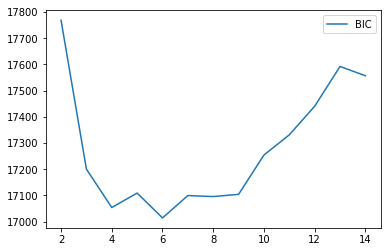

In [17]:
# using Gaussian Mixture Model and BIC score to select appropriate number of clusters
from sklearn.mixture import GaussianMixture
n_components=np.arange(2,15)
models=[GaussianMixture(n,covariance_type='full',random_state=0,max_iter=100).fit(X_6) for n in n_components]
plt.plot(n_components,[m.bic(X_6) for m in models],label='BIC')
plt.legend(loc='best')
# 6 is the best, but we choose 4 here, which is also good

In [18]:
# include the clustering label in the dataframe
est=GaussianMixture(4,covariance_type='full',random_state=0,max_iter=100).fit(X_6)
y=est.predict(X_6)
X_total=X.iloc[:,:24].copy()
X_total['label']=y

In [19]:
X_total.head()

index,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,label
ID,,,,,,,,,,,,,,,,,,,,,
2,32.678318,32.888095,33.068803,33.104322,33.100446,33.015648,32.805514,32.340884,31.257370,29.966706,...,31.770030,32.738547,33.051314,33.557915,32.949213,31.682891,30.739045,30.323173,30.508791,0
3,20.291726,20.215268,20.196259,20.200994,20.170449,20.205729,20.377604,22.279989,27.013002,32.872854,...,31.470975,21.721702,15.475035,16.691325,19.334795,21.260137,21.270863,20.191737,19.383475,3
4,33.694960,33.701754,33.727509,33.745502,33.750591,33.768703,33.697325,33.772727,34.672408,36.041040,...,36.981203,36.558068,35.920480,35.540311,36.055587,35.674682,34.874823,34.239849,33.793620,0
5,43.729375,44.043747,44.154321,44.088651,44.073495,44.178300,44.182882,43.019773,39.327792,39.210790,...,39.879184,39.038860,38.518040,43.701653,44.926714,44.081087,43.095508,42.414631,42.106125,0
6,25.972991,25.896633,25.870265,25.856771,25.903073,25.939394,25.797254,26.549384,27.518251,27.746801,...,24.622048,25.688014,27.720128,27.743989,26.245686,26.188826,26.102216,25.132436,25.194046,0


In [20]:
# group by different labels to see the difference between each group
X_group=X_total.iloc[:,:25].groupby(by='label').mean().T

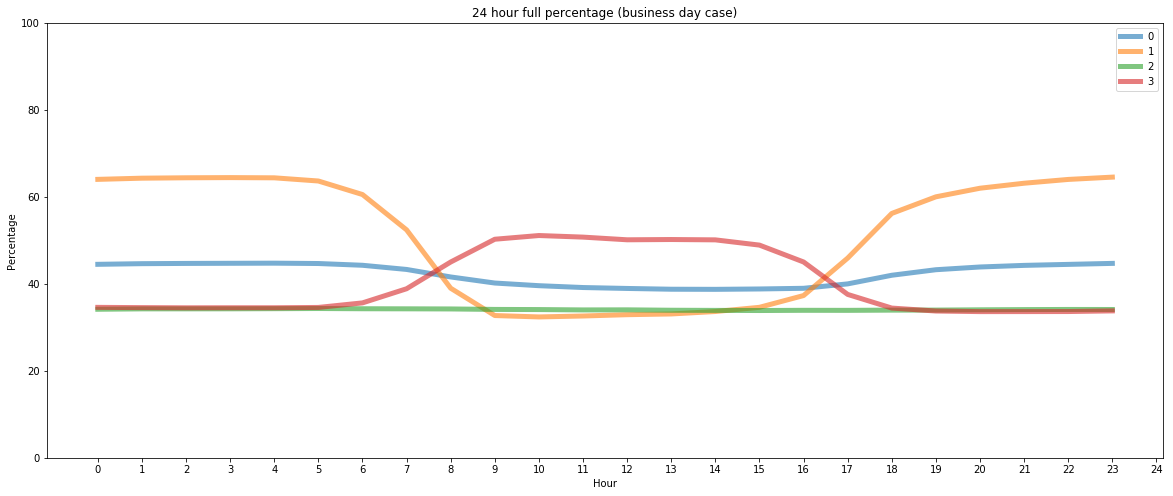

In [21]:
fig,ax =plt.subplots(figsize=(20,8))
hourly_ticks=np.arange(0,25)
X_group.plot(ax=ax,xticks=hourly_ticks,linewidth=5,alpha=0.6)
plt.ylim(0,100)
plt.title('24 hour full percentage (business day case)')
plt.xlabel('Hour')
plt.ylabel('Percentage')
plt.legend(loc='best')

## Step 3: A first glance at all groups
From the above graph, we can see that four groups behave differently:

**Group 0**: has a **stable** 24 hour full percentage, higher than Group 2

**Group 1**: **high** full percentage during moring and night, **low** full percentage during daytime

**Group 2**: has a **stable** 24 hour full percentage, lower than Group 0

**Group 3**: **low** full percentage during moring and night, **high** full percentage during daytime

In [22]:
# combine with GPS location in order to plot the stations
X_combined=pd.merge(GPS,X_total,left_index=True,right_index=True)

In [23]:
# convert from longitude and latitude to Mercator coordinate system
import math
from ast import literal_eval
def merc(lon,lat):
    #Coordinates = literal_eval(Coords)
    r_major = 6378137.000
    x = r_major * math.radians(lon)
    scale = x/lon
    y = 180.0/math.pi * math.log(math.tan(math.pi/4.0 + 
        lat * (math.pi/180.0)/2.0)) * scale
    return (x, y)
X_combined['coords_x'] = X_combined[['Longitude','Latitude']].apply(lambda row: merc(row[0],row[1])[0],axis=1)
X_combined['coords_y'] = X_combined[['Longitude','Latitude']].apply(lambda row: merc(row[0],row[1])[1],axis=1)

In [24]:
from bokeh.plotting import Figure, output_file, show
from bokeh.models import BoxSelectTool, BoxZoomTool, LassoSelectTool
from bokeh.layouts import column,row
from bokeh.tile_providers import CARTODBPOSITRON

p1 = Figure(plot_width=550, plot_height=550,x_range=(-9780000, -9745000), y_range=(5130000, 5160000),
           x_axis_type="mercator", y_axis_type="mercator")
p1.add_tile(CARTODBPOSITRON)

p1.title.text = '4 Groups of Stations (Business Day)'

for label,color in zip([0,1,2,3], Set1_9):
    G=X_combined[X_combined['label']==label][['coords_x','coords_y']]
    r=p1.circle(G['coords_x'], G['coords_y'], size=5, color=color, alpha=0.8, muted_color=color, muted_alpha=0.1, legend=str(label))
    r.muted = True

p1.legend.location = "top_right"
p1.legend.click_policy="mute"

In [25]:
show(p1)

## Step 4: Further explanations
The graph above explains the full percentage behaviours of each group

**Group 0**: has a **stable** 24 hour full percentage, higher than Group 2

**Reason:** They mainly locate on the service boundary. Not many people use those stations, so the full percentage rarely changes.

**Group 1**: **high** full percentage during moring and night, **low** full percentage during daytime

**Reason:** They mainly locate at living areas. In the morning, there are lots of bicycles. Then people ride them to work, which results in a dramatic decrease of Full Percentage around 6:00-8:00. During daytime, there are few number of bicycles until people ride bicycles from work to home around 16:00-18:00.

**Group 2**: has a **stable** 24 hour full percentage, lower than Group 0

**Reason:** They are even farther comparing to Group 0. Not many people use those stations, so the full percentage rarely changes. Comparing to Group 0, the company also provides less bicycles for those stations.

**Group 3**: **low** full percentage during moring and night, **high** full percentage during daytime

**Reason:** They mainly locate at working areas (downtown Chicago). In the morning, there are few bicycles. Then people ride bicycles from home to work, which results in a dramatic increase of Full Percentage around 6:00-8:00. During daytime, there are lots of bicycles until people ride bicycles back to home around 16:00-18:00.

## Remark: Similar analysis can be done for weekend information, and we will skip it here

# 2) Predict the future station usage using time series models
## Step 1: Clean the data

In [27]:
# clean the dataframe
# index = hourly time stamps for a year
# column = station ID
X_ml=df.T.loc[GPS.index,:]
X_ml.fillna(0,inplace=True)
test=X_ml.T
test.sort_index(ascending=True,inplace=True)
test=test.iloc[-8760:,:]
test.head()

ID,2,3,4,5,6,7,9,11,12,13,...,620,621,622,623,624,625,626,627,630,631
index,,,,,,,,,,,,,,,,,,,,,
2017-09-18 01:00:00,41.0,2.0,23.0,59.0,33.0,84.000000,17.0,36.0,33.0,73.000000,...,21.000000,0.0,71.0,65.0,88.0,33.0,0.0,0.0,0.0,0.0
2017-09-18 02:00:00,41.0,2.0,23.0,59.0,33.0,84.000000,17.0,36.0,33.0,73.000000,...,21.000000,0.0,71.0,65.0,88.0,33.0,0.0,0.0,0.0,0.0
2017-09-18 03:00:00,41.0,2.0,23.0,59.0,33.0,84.000000,17.0,36.0,33.0,74.333333,...,21.000000,0.0,71.0,65.0,88.0,33.0,0.0,0.0,0.0,0.0
2017-09-18 04:00:00,41.0,2.0,23.0,59.0,33.0,83.166667,17.0,36.0,33.0,77.000000,...,21.000000,0.0,71.0,65.0,88.0,33.0,0.0,0.0,0.0,0.0
2017-09-18 05:00:00,41.0,2.0,23.0,59.0,34.0,78.166667,17.0,36.0,33.0,81.000000,...,16.333333,0.0,71.0,65.0,88.0,33.0,0.0,0.0,0.0,0.0


## Step 2: Define a HoltWinter Model Class

In [29]:
# define a HoltWinter Model class
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [33]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error,mean_squared_log_error
from scipy.optimize import minimize 
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [31]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [36]:
# a function to plot the HoltWinters prediction
def plotHoltWinters(c, model, L, pred_index, plot_intervals=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    series=test.loc[:,c][-1334:]
    train_date=pd.date_range('2018-07-26 00:00:00',periods=1334,freq='H')
    total_date=pd.date_range('2018-07-26 00:00:00',periods=1334+168,freq='H')
    plt.figure(figsize=(48, 3))
    plt.plot(total_date[-(L+168+14):],model.result[-(L+168+14):], label = "Model")
    plt.plot(train_date[-(L+14):],series.values[-(L+14):], label = "Actual")
    #plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_intervals:
        plt.plot(total_date[-(L+168+14):],model.UpperBond[-(L+168+14):], "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(total_date[-(L+168+14):],model.LowerBond[-(L+168+14):], "r--", alpha=0.5)
        plt.fill_between(x=total_date[-(L+168+14):], y1=model.UpperBond[-(L+168+14):], 
                         y2=model.LowerBond[-(L+168+14):], alpha=0.2, color = "grey")    
        
    plt.vlines(train_date[-1], ymin=0, ymax=100, linestyles='dashed')
    plt.vlines(total_date[pred_index], ymin=0, ymax=100, linestyles='solid',colors='red',linewidth=3)
    plt.axvspan(train_date[-1],total_date[-1], alpha=0.3, color='lightgrey')
    
    plt.grid(True)
    plt.axis('tight')
    plt.ylim(0,100)
    ax = plt.gca()
    ticks_to_use = total_date[-(L+168+14)::24]
    labels = [ i.strftime("%m/%d") for i in ticks_to_use ]
    ax.set_xticks(ticks_to_use)
    ax.set_xticklabels(labels)
    plt.title('Historical Data and Predictions for Station {}'.format(str(c)))
    plt.legend(loc="best", fontsize=13);

## Step 3: Compute the HoltWinters model for each station

In [ ]:
# pre-compute all the HoltWinters models and save the model coefficients locally
from collections import defaultdict

d=defaultdict(tuple)
cnt=0
for c in test.columns:
    cnt+=1
    xxx=test.loc[:,c]
    xxx.fillna(0,inplace=True)
    data=xxx[-1344:]
    x = [0, 0, 0] 

    opt = minimize(timeseriesCVscore, x0=x, args=(data, mean_squared_error),
                   method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

    alpha_final, beta_final, gamma_final = opt.x
    d[c]=(alpha_final, beta_final, gamma_final)
    if cnt%15==0:
        print('{} is done'.format(cnt))

In [37]:
import json

# writing
#json.dump(result, open('ts_coeff.json', 'w'))

# reading
model_coeff = json.load(open('ts_coeff.json'))

## One example for staton #37

In [38]:
# An example, the model for Station #37
c=37
model = HoltWinters(test.loc[:,c][-1334:], slen = 168, 
                    alpha = model_coeff[str(c)][0], 
                    beta = model_coeff[str(c)][1], 
                    gamma = model_coeff[str(c)][2], 
                    n_preds = 168, scaling_factor = 1.645) # 1.645,1.96,2.576 for %90/95/99 CI, 
model.triple_exponential_smoothing()

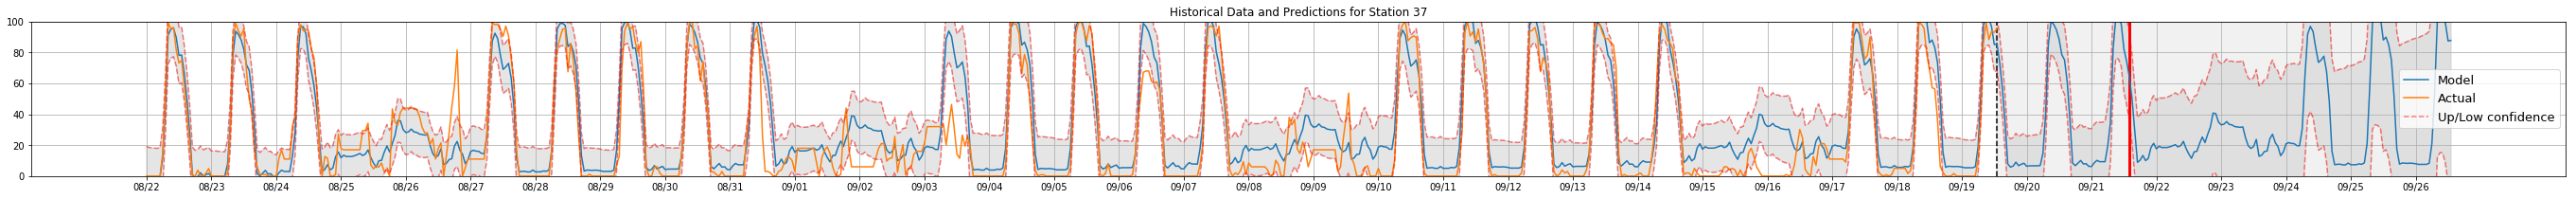

In [40]:
# prediction of station #37 with 90% confidence interval
# click to enlarge the graph
future_time='2018-09-21 14:00:00'
total_date=pd.date_range('2018-07-26 00:00:00',periods=1334+168,freq='H')
pred_index=list(map(str,total_date)).index(future_time)
plotHoltWinters(c,model,672,pred_index,plot_intervals=True)

## Step 4: Compute nearest stations given a GPS location

In [41]:
# the lat/lon data user entered
test_lat=41.882 
test_lon=-87.63
# future time
future_time='2018-09-21 14:00:00'

In [42]:
# generate a distance series
dist_matrix=np.abs(GPS['Latitude']-test_lat)+np.abs(GPS['Longitude']-test_lon)

In [43]:
# returns a list of IDs of n nearest stations
nearest_station_list=[dist_matrix.index[i] for i in dist_matrix.values.argsort()[0:3]]

In [44]:
nearest_station_list

[49, 81, 37]

In [45]:
def find_stations(test_lat,test_lon,n):
    dist_matrix=np.abs(GPS['Latitude']-test_lat)+np.abs(GPS['Longitude']-test_lon)
    nearest_station_list=[dist_matrix.index[i] for i in dist_matrix.values.argsort()[0:n]]
    return nearest_station_list

## One example for predictions of station usages at 2018-09-21 14:00:00 for the nearest 3 stations near the GPS location lat=41.882, lon=-87.63

In [46]:
def plot_pred(future_time,nearest_station_list):
    ans_stat=[]
    L=672
    #future_time='2018-09-21 14:00:00'
    total_date=pd.date_range('2018-07-26 00:00:00',periods=1334+168,freq='H')
    pred_index=list(map(str,total_date)).index(future_time)

    for c in nearest_station_list:
        data=test.loc[:,c][-1334:]

        model = HoltWinters(data, slen = 168, 
                            alpha = model_coeff[str(c)][0], 
                            beta = model_coeff[str(c)][1], 
                            gamma = model_coeff[str(c)][2], 
                            n_preds = 168, scaling_factor = 1.645) # 1.645,1.96,2.576 %90/95/99, 
        model.triple_exponential_smoothing()
        ans_stat.append((c,model.result[pred_index]))
        plotHoltWinters(c,model,L,pred_index)    
    return ans_stat

[(49, 78.39456810902709), (81, 59.12892038124622), (37, 64.15362428672356)]

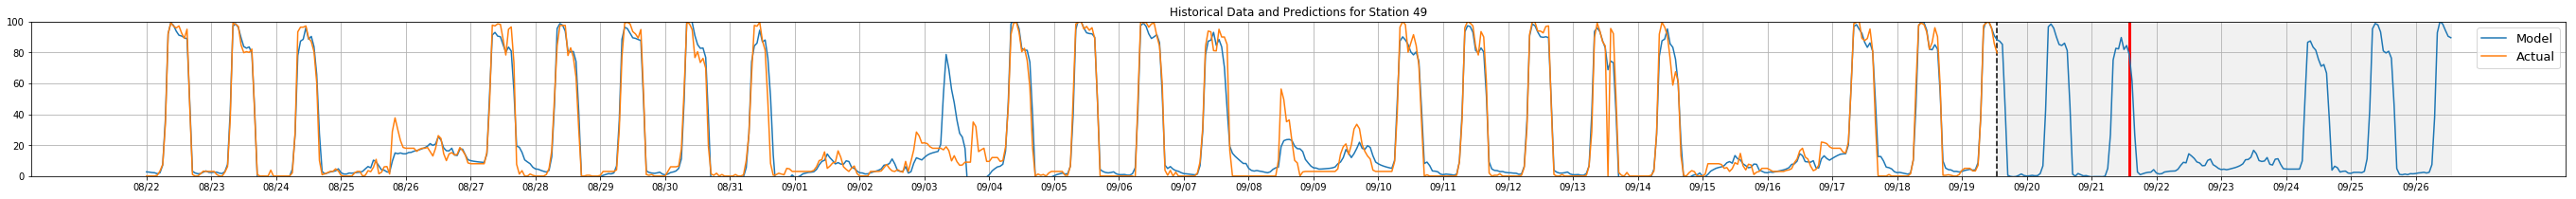

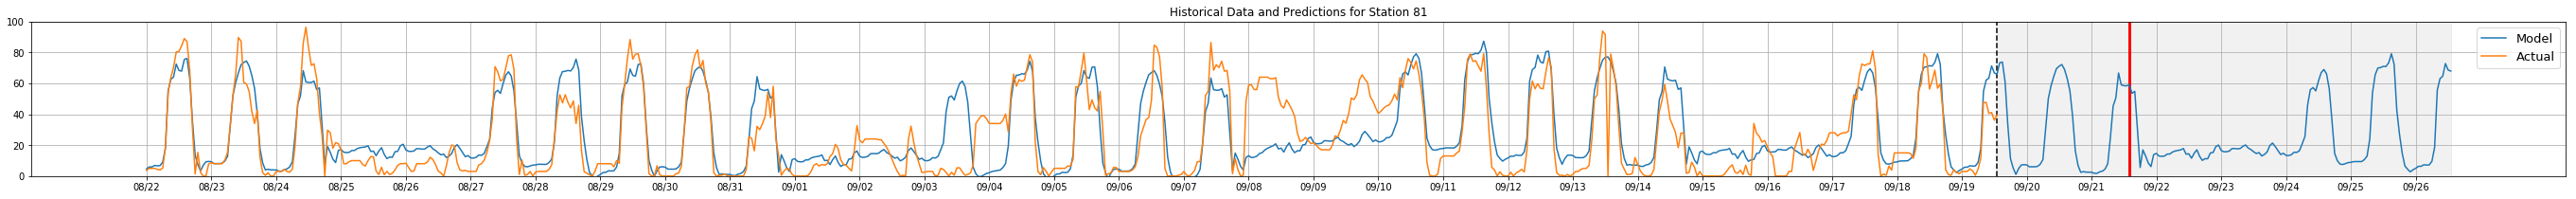

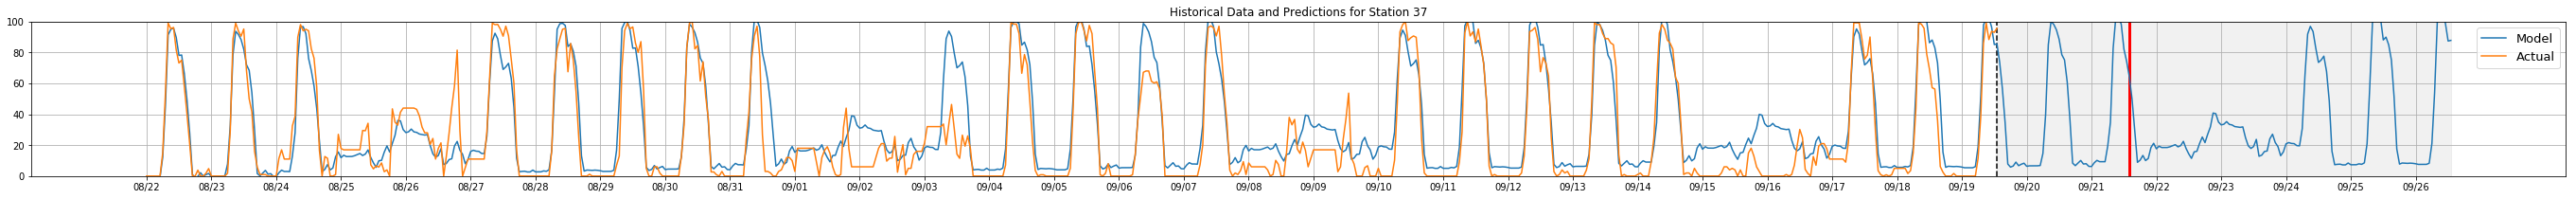

In [55]:
# the red line corresponds to 2018-09-21 14:00:00
plot_pred(future_time,nearest_station_list)

## Step 5: User Interface
the user can enter a GPS location, a future time, and select nearest 3/5 stations for finding bicycles or docks

the model will return prediction graphs along with a map showing the rank of those nearest station

In [48]:
from IPython.display import display
import ipywidgets as widgets
import datetime

In [49]:
GPS['coords_x'] = GPS[['Longitude','Latitude']].apply(lambda row: merc(row[0],row[1])[0],axis=1)
GPS['coords_y'] = GPS[['Longitude','Latitude']].apply(lambda row: merc(row[0],row[1])[1],axis=1)

In [50]:
a=widgets.Text(description='Latitude: ',value='41.882', disabled=False)
b=widgets.Text(description='Longitude: ',value='-87.630',disabled=False)
c=widgets.Text(description='Date/Time: ', value='2018-09-21 14:00:00', disabled=False)
d=widgets.RadioButtons(options=[('nearest 3 stations',3), ('nearest 5 stations',5)],
                       description='Select One:',
                       disabled=False)
e=widgets.RadioButtons(options=[('finding bikes',-1), ('finding docks',1)],
                       description='Select One:',
                       disabled=False)
display(a,b,c,d,e)

Text(value='41.882', description='Latitude: ')

Text(value='-87.630', description='Longitude: ')

Text(value='2018-09-21 14:00:00', description='Date/Time: ')

RadioButtons(description='Select One:', options=(('nearest 3 stations', 3), ('nearest 5 stations', 5)), value=…

RadioButtons(description='Select One:', options=(('finding bikes', -1), ('finding docks', 1)), value=-1)

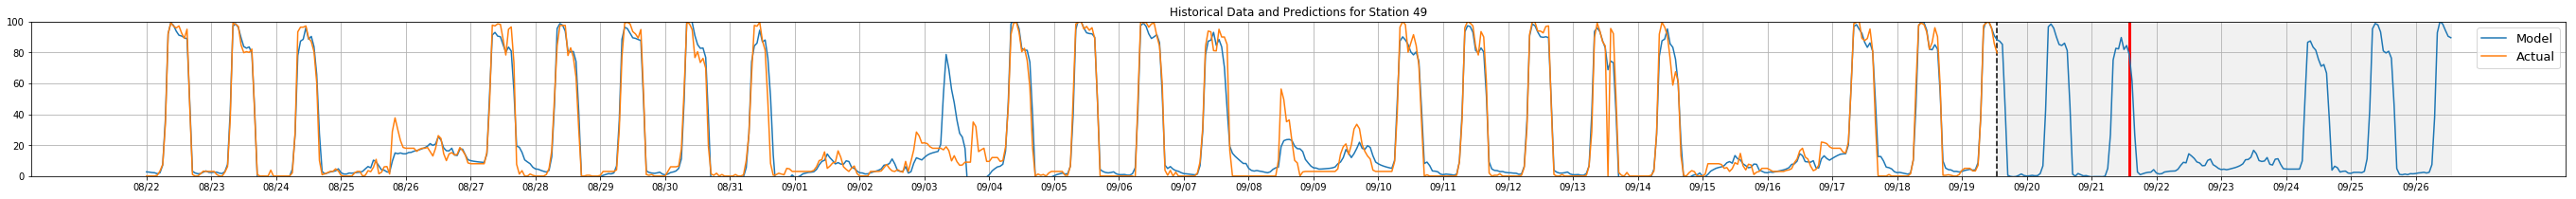

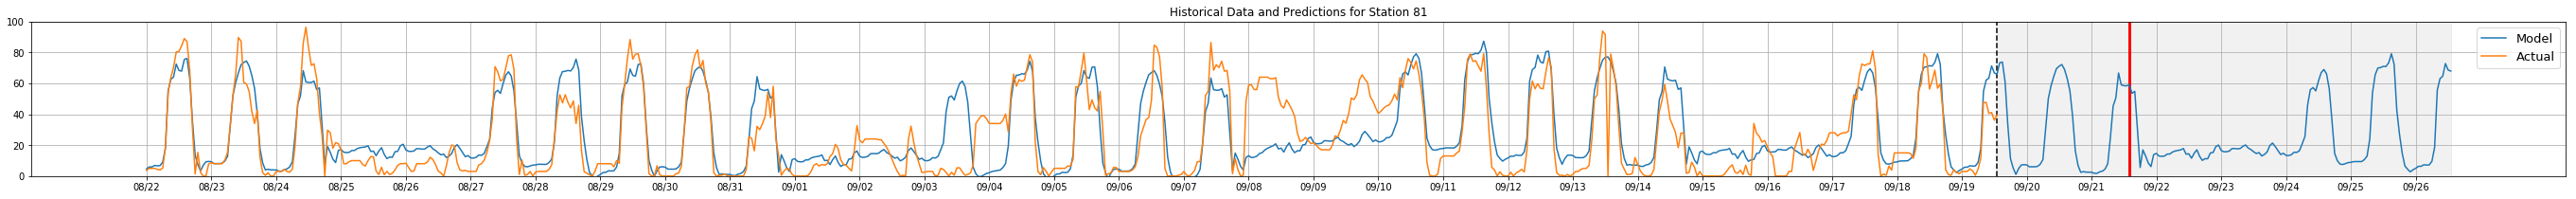

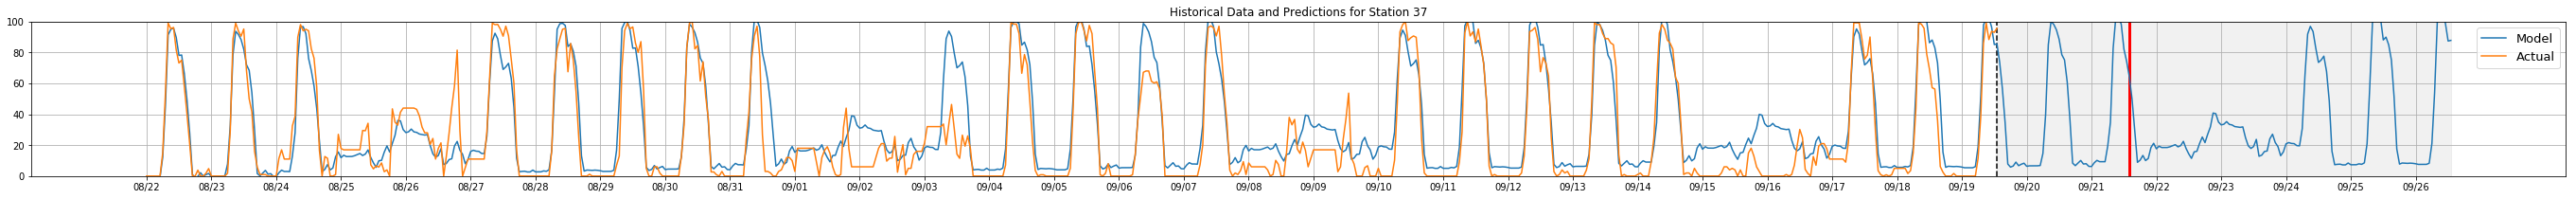

In [51]:
e_dict={1:'finding docks', -1:'finding bikes'}
nearest_station_list=find_stations(float(a.value),float(b.value),d.value)
pred_list=plot_pred(c.value,nearest_station_list)

In [52]:
print('At {} \n'.format(c.value))
for pair in pred_list:
    print('station {} is predicted to be {:.2f}% full'.format(pair[0],pair[1]))

At 2018-09-21 14:00:00 

station 49 is predicted to be 78.39% full
station 81 is predicted to be 59.13% full
station 37 is predicted to be 64.15% full


In [53]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.models.glyphs import Text

sorted_pred_list=sorted(pred_list,key=lambda x:x[1]*e.value)

x_0,y_0=merc(float(b.value),float(a.value))

p = Figure(plot_width=550, plot_height=550,x_range=(x_0-1000, x_0+1000), y_range=(y_0-1000, y_0+1000),
           x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(CARTODBPOSITRON)

G=GPS.loc[[row[0] for row in sorted_pred_list]][['coords_x','coords_y']]

names=['Station #'+str(G.index[i])+'(rank '+str(i+1)+')' for i in range(3)]

p.title.text = 'nearest {} stations for {}'.format(d.value,e_dict[e.value])

r=p.x(x_0, y_0, size=10, color='blue', alpha=0.8,line_width=3,legend='targeted location')

for row in range(d.value):
    r=p.circle(G.iloc[row]['coords_x'], G.iloc[row]['coords_y'], size=sorted_pred_list[row][1]/3, color='red', alpha=0.5,legend='nearest {} stations'.format(d.value))
    p.x(G.iloc[row]['coords_x'], G.iloc[row]['coords_y'], size=10, color='white',line_width=3)
    #r.muted = True

p.legend.location = "top_right"


source = ColumnDataSource(data=dict(x_coord=G['coords_x'],
                                    y_coord=G['coords_y'],
                                    names=names))

labels = LabelSet(x='x_coord', y='y_coord', text='names', level='glyph',
              x_offset=0, y_offset=10, source=source, render_mode='canvas')


p.add_layout(labels)

In [54]:
show(p)